In [1]:
from utils import *
from scipy.optimize import curve_fit
import mpu

In [2]:
# import data
snakemake_contigs = SeqIO.to_dict(SeqIO.parse('/home/tobamo/analize/model-tobamo/data/snakemake_output/test_contigs_2024-04-09_non_cellular.fasta', "fasta"))

# extract contig names and lengths
df = pd.DataFrame({
    'contig_name': list(snakemake_contigs.keys()),
    'contig_length': [len(str(record.seq)) for record in snakemake_contigs.values()]
})

# Extract SRR from contig names and identify problematic contigs
df['SRR'] = df['contig_name'].str.extract(r"_([A-Za-z0-9]+)$")
df['problematic'] = df['SRR'] == 'SRR6846476' # 1873 contigs

# Filter out problematic contigs
df_filtered = df[~df['problematic']].copy()
sample = df_filtered['contig_length'].to_list()

[630.08666667 678.26       726.43333333] [0.00135728 0.00135728 0.00091816]
[ 7.93139545e-03  3.05621468e-03 -1.81668155e-08  1.58731686e-04]
range(600, 603) [0.0014154  0.00141151 0.00140764]
range(7998, 8001) [1.34334957e-05 1.34153289e-05 1.33971621e-05]
y_fitted: [0.0014154  0.00141151 0.00140764] [1.34334957e-05 1.34153289e-05 1.33971621e-05]
sum: 1.0120121280554375
y_fitted: [0.0013986  0.00139476 0.00139093] [1.32740461e-05 1.32560950e-05 1.32381438e-05]
sum: 1.0000000000000062


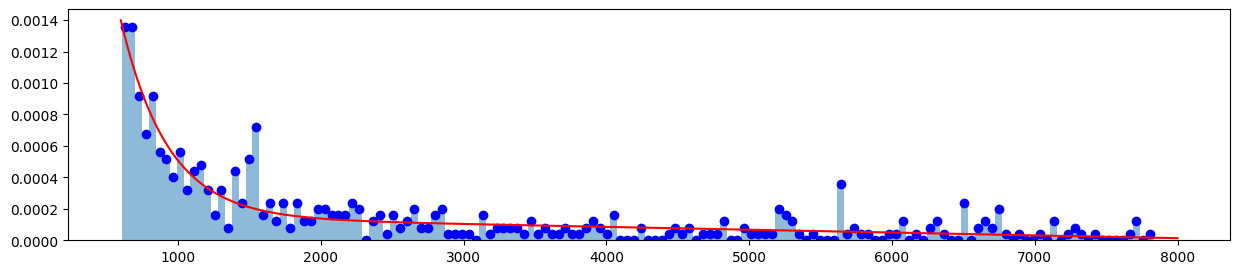

In [3]:
# bin the data
bins = 150
ydata, bin_edges = np.histogram(sample, bins=bins, density=True)
xdata = 0.5 * (bin_edges[1:] + bin_edges[:-1])
print(xdata[:3], ydata[:3])

# fit function to binned data
def func2(x, a, b, c, d):
    return a * np.exp(-b * x) + c*x + d

p0 = [4, 0.002, -0.0001, 0.001]  # initial guess for parameters
popt, pcov = curve_fit(func2, xdata, ydata, p0=p0, maxfev=10000)
print(popt)

# fit to needed range
xfine = range(600, 8000+1)
y_fitted = func2(xfine, *popt)  # popt[0], popt[1], popt[2])

# xfine and y-fitted to be used for weighted sampling
print(xfine[:3], y_fitted[:3])
print(xfine[-3:], y_fitted[-3:])

print('y_fitted:', y_fitted[:3], y_fitted[-3:])
print('sum:', sum(y_fitted))
# make sure it sums to 1.0
y_fitted /= sum(y_fitted)
print('y_fitted:', y_fitted[:3], y_fitted[-3:])
print('sum:', sum(y_fitted))

# plot the data
plt.figure(figsize=(15, 3))
plt.hist(sample, bins=bins, density=True, alpha=0.5)
plt.plot(xdata, ydata, 'bo')

# plot the fitted function
plt.plot(xfine, y_fitted, 'r-')

# Create a dictionary from two equally long lists: xfine and y_fitted
xy_dict = dict(zip(xfine, y_fitted))

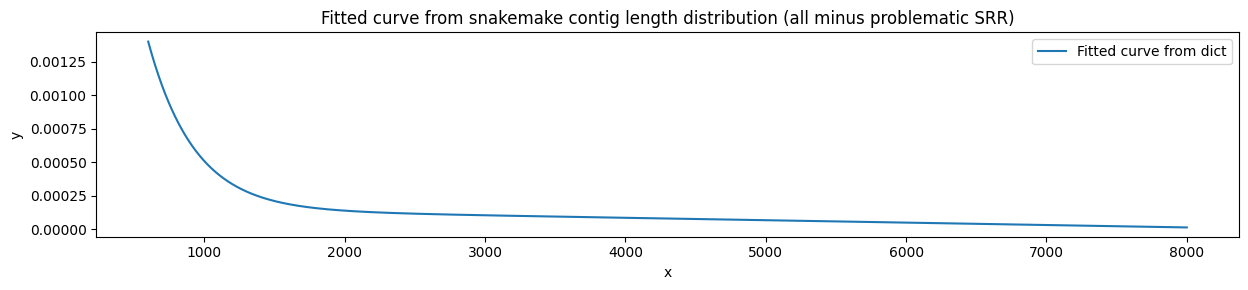

In [4]:
# Plot the dictionary: keys as x, values as y

fig, ax = plt.subplots(figsize=(12.5, 3))
ax.plot(list(xy_dict.keys()), list(xy_dict.values()), label='Fitted curve from dict')
# ax.axvline(600, color='black')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Fitted curve from snakemake contig length distribution (all minus problematic SRR)')
plt.legend()
plt.tight_layout()
plt.show()

export dictionary of frequences for sampling

In [5]:
# os.makedirs('results/training/sampling', exist_ok=True)
# mpu.io.write('results/training/sampling/fitted_curve_lens_freq.json', xy_dict)

In [6]:
sampled_contigs = SeqIO.to_dict(SeqIO.parse('/home/tobamo/analize/model-tobamo/notebooks/MODEL4/results/training/sampling/2025-06-11_sampled_contigs_60.fasta', "fasta"))

# extract contig names and lengths
df = pd.DataFrame({
    'contig_name': list(sampled_contigs.keys()),
    'contig_length': [len(str(record.seq)) for record in sampled_contigs.values()]
})

new_sample = df['contig_length'].to_list()

In [7]:
min(new_sample), max(new_sample)

(600, 7226)

In [8]:
# bin the data
bins = 150
ydata, bin_edges = np.histogram(new_sample, bins=bins, density=True)
xdata = 0.5 * (bin_edges[1:] + bin_edges[:-1])
print(xdata[:3], ydata[:3])

# fit function to binned data
def func2(x, a, b, c, d):
    return a * np.exp(-b * x) + c*x + d

p0 = [7.93139545e-03, 3.05621468e-03, -1.81668155e-08, 1.58731686e-04]  # initial guess for parameters
popt, pcov = curve_fit(func2, xdata, ydata, p0=p0, maxfev=10000)
print(popt)

[622.08666667 666.26       710.43333333] [0.001476   0.00115605 0.00122849]
[ 7.66357968e-03  2.86359429e-03 -2.35521095e-08  1.70670890e-04]


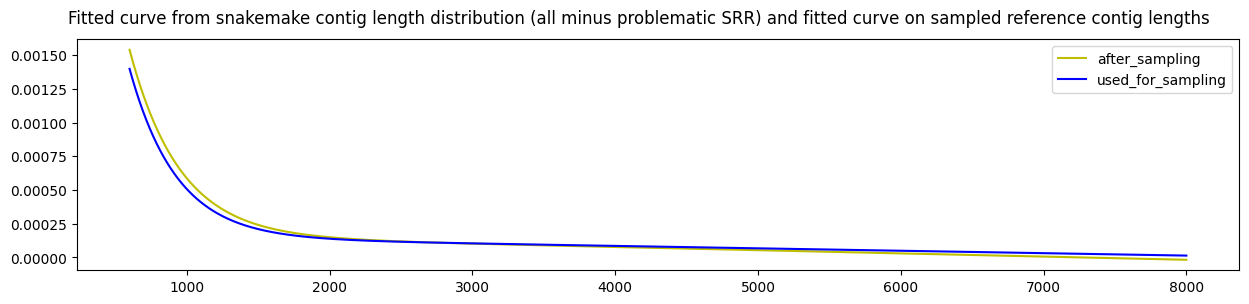

In [14]:
# fit to needed range
xfine = range(600, 8000+1)
sample_y_fitted = func2(xfine, *popt)  # popt[0], popt[1], popt[2])
# make sure it sums to 1.0
sample_y_fitted /= sum(sample_y_fitted)

# plot the data
plt.figure(figsize=(15, 3))

# plot the fitted function
plt.plot(xfine, sample_y_fitted, 'y-', label='after_sampling')
plt.plot(xfine, y_fitted, 'b-', label='used_for_sampling')
plt.suptitle('Fitted curve from snakemake contig length distribution (all minus problematic SRR) and fitted curve on sampled reference contig lengths')
plt.legend()
plt.show()